# Feature Selection
We have 10 images with 5 bands each. We know that some of the images are relatively close to one another temporally, and therefore expect that some of these images are redundant and can be removed, or combined in some way to reduce the feature space.  This script attempts to determine which (if any) of these features can be removed.

In [1]:
from sklearn import decomposition
import common, tqdm, numpy as np
import pandas as pd
import preprocess


First, load the images and normalize all of the bands by converting their values to Z-values, which as we determined earlier was appropriate. 

In [2]:
images = preprocess.loadZValues()

100%|██████████| 10/10 [01:43<00:00, 10.39s/it]


We start with PCA to determine how much redundancy there is in the dataset.

In [3]:
from numpy import random
h,w,_ = images[0][1].shape
selected_idx = random.random_integers(0,h*w,25000)

subset = [im[1][:,:,band].flatten()[selected_idx].reshape(-1,1) for im in images for band in range(im[1].shape[2]) ]

features = np.concatenate(subset,axis=1)
print(features.shape)
pca = decomposition.PCA(n_components='mle')
pca.fit(features)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 19014446 + 1) instead
  app.launch_new_instance()


(25000, 50)


PCA(copy=True, iterated_power='auto', n_components='mle', random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [4]:
ratio = pca.explained_variance_ratio_
cumRatio = np.cumsum(pca.explained_variance_ratio_)

for k, ratios in enumerate(zip(ratio,cumRatio)):
    r1, c1 = ratios
    print('component {} : explained variance: {:.2f}, cum explained variance {:.2f}'.format(k,r1,c1))


component 0 : explained variance: 0.57, cum explained variance 0.57
component 1 : explained variance: 0.10, cum explained variance 0.67
component 2 : explained variance: 0.08, cum explained variance 0.75
component 3 : explained variance: 0.04, cum explained variance 0.79
component 4 : explained variance: 0.03, cum explained variance 0.83
component 5 : explained variance: 0.03, cum explained variance 0.85
component 6 : explained variance: 0.02, cum explained variance 0.88
component 7 : explained variance: 0.02, cum explained variance 0.89
component 8 : explained variance: 0.02, cum explained variance 0.91
component 9 : explained variance: 0.01, cum explained variance 0.92
component 10 : explained variance: 0.01, cum explained variance 0.93
component 11 : explained variance: 0.01, cum explained variance 0.94
component 12 : explained variance: 0.01, cum explained variance 0.95
component 13 : explained variance: 0.01, cum explained variance 0.96
component 14 : explained variance: 0.01, cum

The PCA transformation has automatically estimated that we need 49 components to reconstruct the original data, but by looking at the explained variance ratios we can see that the first principal component explains about 56% of the variance in the dataset. Subsequent components (out to about the 15th component) account for about 97% of the variance in the original data. PCA is clearly showing that there is a significant amount of redundancy in this data, which maybe is to be expected.

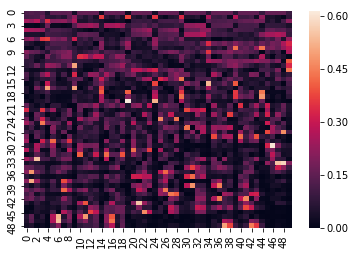

In [21]:
import seaborn
seaborn.heatmap(abs(pca.components_))

The plot above shows a heatmap of the PCA principal components where each row is a single component, and each column represents the contribution from each individual feature.  For PCA to be maximally useful, we'd like to see that the main components have a clear meaning in feature space, e.g. the first principal component is band1 of image 1 and band 3 of image 4.  Unfortunately in this case, it looks like most of the components are mixed combinations of multiple bands from multiple images simultaneously.  I would note though that it looks like the 2nd or third principal component may be just a combination of the 5th band from each image, which is interesting.

In [6]:
for k in range(10):
    print('component: ', k, pca.components_[k])

component:  0 [0.12384352 0.13302112 0.12318528 0.13241464 0.05433704 0.15032274
 0.15091398 0.14694573 0.14932235 0.03955434 0.158548   0.16174862
 0.15697551 0.16020432 0.02508592 0.1625632  0.16481063 0.15825588
 0.16072737 0.02303109 0.16486393 0.16648425 0.1603151  0.1594478
 0.03534589 0.16467056 0.16587658 0.16012263 0.15701465 0.03058382
 0.15600777 0.15901567 0.15432794 0.15056066 0.06813902 0.1573029
 0.16051185 0.15660863 0.15864536 0.06894961 0.15430543 0.15635459
 0.15433633 0.1554553  0.08881591 0.16060226 0.16112192 0.15776198
 0.15685485 0.0950228 ]
component:  1 [-0.10937796 -0.11579666 -0.12133425 -0.16169336 -0.07043201 -0.06645647
 -0.08019239 -0.06242517 -0.14150953 -0.22381851  0.08685331  0.05526679
  0.08984254 -0.03652627 -0.36352298  0.07449858  0.04805976  0.08643958
 -0.04094175 -0.3764759   0.06030219  0.04004849  0.07531764 -0.01998697
 -0.3520056   0.03183958  0.01359012  0.05118063 -0.06377921 -0.33557585
  0.05274951  0.04766878  0.06451853 -0.01492358 

Since PCA is not really illuminating which features are most important, another way to take a stab at figuring out which features are important is to fit a simple model to the data and use attributes of the resultant model to figure out which features are most important. Tree based models are usually a good choice for this approach, I prefer Random Forests for this task since they're simple and robust.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

In [8]:
labels = common.loadNumpy('labels')
y = labels.squeeze().flatten()[selected_idx].reshape(-1,1)

xtr,xte,ytr,yte = train_test_split(features,y,train_size=0.8)
rf = RandomForestClassifier()
rf.fit(xtr,ytr)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [9]:
def conf_matrix(yte,ypr):
    p,r,f,s  =precision_recall_fscore_support(yte,ypr,
                                              average=None)
    df = pd.DataFrame()
    df.index.name = 'Class'
    df['Precision'] = p
    df['Recall'] = r
    df['F1'] = f
    df['Support'] = s
    print(df)

    print(confusion_matrix(yte,ypr))
    
def score(classifier, xtr,ytr,xte,yte):
    print('train score', classifier.score(xtr,ytr))
    print('test score', classifier.score(xte,yte))

    print('>>> Confusion Matrix Train <<<')
    conf_matrix(ytr, classifier.predict(xtr))
    print('>>> Confusion Matrix Test <<<')
    conf_matrix(yte,classifier.predict(xte))
    
    

In [10]:
score(rf,xtr,ytr,xte,yte)

train score 0.9871
test score 0.7256
>>> Confusion Matrix Train <<<
    Precision    Recall        F1  Support
0    0.983607  0.992556  0.988061     1209
1    0.983521  0.998282  0.990847     8729
2    0.985813  0.987414  0.986613     4926
3    0.996801  0.992989  0.994891     1569
4    0.996032  0.917174  0.954978      821
5    0.989346  0.996933  0.993125      652
6    1.000000  0.979048  0.989413      525
7    0.997732  0.946237  0.971302      465
8    0.992268  0.969773  0.980892      397
9    0.990991  0.942857  0.966325      350
10   1.000000  0.935574  0.966715      357
[[1200    2    4    0    0    1    0    1    0    1    0]
 [   2 8714   11    0    0    0    0    0    2    0    0]
 [   3   58 4864    1    0    0    0    0    0    0    0]
 [   2    4    4 1558    0    0    0    0    0    1    0]
 [   2   55   10    1  753    0    0    0    0    0    0]
 [   1    1    0    0    0  650    0    0    0    0    0]
 [   1    3    1    0    0    6  514    0    0    0    0]
 [   2    

This model performs well on the training dataset, but not so well on the test dataset.  Overall the performance is decent, but we're seeing clearly in the confusion matrices that we're not predicting well on class 0, 1, and 2 to a lesser extent in the test dataset.  Since we're not using this for our final model we can ignore this for now.

In [11]:
imp = rf.feature_importances_
print(imp.min(), imp.max())

0.010906553476275173 0.06322775530024002


The feature importances from the random forest classifier are not super helpful either.  They're showing that the biggest range from the most useful to least useful feature is only about a factor of 6, which is not huge and probably means that we would be better off leaving all of the features in our dataset.

The last test to run is to pit PCA's recommended 15 variables in a Random Forest classifier and see how well it performs relative to what we just observed above.



In [12]:
pca2 = decomposition.PCA(n_components=15)
pca2.fit(features)
ftransform = pca2.transform(features)
print(ftransform.shape)
xtr2,xte2, ytr2,yte2= train_test_split(ftransform,y,train_size=0.8)

(25000, 15)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [13]:
rf2 = RandomForestClassifier()
print(xtr2.shape, ytr2.shape, xte2.shape,yte2.shape)
rf2.fit(xtr2,ytr2)

(20000, 15) (20000, 1) (5000, 15) (5000, 1)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
score(rf2,xtr2,ytr2,xte2,yte2)

train score 0.9858
test score 0.7236
>>> Confusion Matrix Train <<<
    Precision    Recall        F1  Support
0    0.986031  0.989283  0.987654     1213
1    0.981397  0.998500  0.989875     8665
2    0.985063  0.987055  0.986058     4944
3    0.992980  0.986058  0.989507     1578
4    0.995973  0.914920  0.953728      811
5    0.989280  0.986260  0.987768      655
6    0.994197  0.979048  0.986564      525
7    0.997773  0.951168  0.973913      471
8    1.000000  0.971014  0.985294      414
9    0.994030  0.922438  0.956897      361
10   0.994203  0.944904  0.968927      363
[[1200    5    2    2    1    0    1    0    0    0    2]
 [   2 8652   10    0    0    0    0    1    0    0    0]
 [   1   60 4880    1    0    1    1    0    0    0    0]
 [   1   14    6 1556    0    0    1    0    0    0    0]
 [   4   53    9    3  742    0    0    0    0    0    0]
 [   3    3    0    3    0  646    0    0    0    0    0]
 [   1    2    2    0    0    6  514    0    0    0    0]
 [   1    

Using the PCA transformed features, with only 15 components (as we identified earlier), the final result here is pretty similar to what we obtained while using all 50 components.  We lost only about .02 accuracy on the test set, while reducing the feature space by almost 3-fold.  That's a pretty good job, and we'll definitely use that going forward, because it should speed-up our compute time significantly.

In [15]:
print(rf2.feature_importances_.min(), rf2.feature_importances_.max())

0.041818823217813626 0.12021557784115226


Also, the range in the values of the feature importances are smaller when using the PCA transformed features.

Here's another way of approaching the feature selection problem, where we use the SelectFromModel class from sklearn with the RF classifier that we fit using all 50 features. This class automatically selects 20 features to use, and based on the train/test score, the result is very close to the original score that we obtained using all 50 features. It's also slightly better than what we obtained using PCA, so this really reinforces the selections that I made using PCA.

In [16]:
from sklearn.feature_selection import SelectFromModel
autoSelector = SelectFromModel(rf,prefit=True)
autoSelector.get_support()

array([ True, False, False, False,  True,  True, False,  True,  True,
        True,  True, False, False,  True,  True, False, False, False,
       False,  True, False, False, False,  True,  True, False, False,
        True,  True,  True, False, False, False, False,  True,  True,
       False, False, False,  True, False, False, False, False,  True,
       False, False, False, False,  True])

In [17]:
xtr3 = autoSelector.transform(xtr)
xte3 = autoSelector.transform(xte)
print(xtr3.shape)

(20000, 20)


In [18]:
rf3 = RandomForestClassifier()
rf3.fit(xtr3,ytr)

score(rf3,xtr3,ytr,xte3,yte)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


train score 0.98645
test score 0.7248
>>> Confusion Matrix Train <<<
    Precision    Recall        F1  Support
0    0.978013  0.993383  0.985638     1209
1    0.982292  0.997709  0.989940     8729
2    0.987031  0.988835  0.987932     4926
3    0.993606  0.990440  0.992020     1569
4    0.998670  0.914738  0.954863      821
5    0.992272  0.984663  0.988453      652
6    0.992293  0.980952  0.986590      525
7    0.997738  0.948387  0.972437      465
8    0.997375  0.957179  0.976864      397
9    0.996988  0.945714  0.970674      350
10   1.000000  0.935574  0.966715      357
[[1201    3    0    1    1    1    0    1    0    1    0]
 [   4 8709   15    1    0    0    0    0    0    0    0]
 [   2   49 4871    4    0    0    0    0    0    0    0]
 [   3    9    3 1554    0    0    0    0    0    0    0]
 [   3   57    7    2  751    1    0    0    0    0    0]
 [   3    1    1    2    0  642    3    0    0    0    0]
 [   3    2    3    0    0    2  515    0    0    0    0]
 [   2   

In [19]:
names = np.array([im[0]+'_'+str(band) for im in images for band in range(im[1].shape[2]) ])

In [20]:
names[autoSelector.get_support()]

array(['20170306_0', '20170306_4', '20170410_0', '20170410_2',
       '20170410_3', '20170410_4', '20170601_0', '20170601_3',
       '20170601_4', '20170615_4', '20170708_3', '20170708_4',
       '20170807_2', '20170807_3', '20170807_4', '20170905_4',
       '20170923_0', '20170923_4', '20171015_4', '20171207_4'],
      dtype='<U10')

The advantage to using SelectFromModel over the PCA approach is that we're able to directly interrogate the selected features. I'm showing in the cell above the features that were selected automatically through this approach. Interestingly, it seems to prefer the fifth band (4th index) for most images. It also seems to naturally select at least one band from each image, indicating that there is some information in each time-slice.